<a href="https://colab.research.google.com/github/yenlung/Python-AI-Book/blob/main/%E5%86%92%E9%9A%AA13_%E8%AE%80%E5%9B%9E%E6%88%91%E5%80%91%E7%9A%84model%EF%BC%8C%E7%94%A8gradio%E7%9E%AC%E9%96%93%E6%89%93%E9%80%A0%E7%B6%B2%E8%B7%AFapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

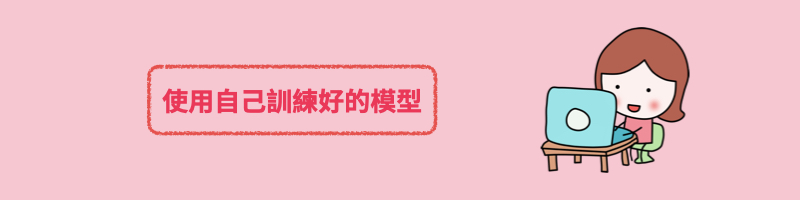

我們看怎麼使用訓練好的模型, 以下的基本套件其實都不用, 這裡只是希望大家養成這種習慣。


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. 安裝 `gradio`

`gradio` 是很酷的套件, 可以幫我們把機器學習的專案神速做成網路 app!

In [2]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.2 MB/s et

讀入套件。

In [3]:
import gradio as gr
from tensorflow.keras.models import load_model

### 2. 讀入我們訓練好的 model

現在連上我們存在 Google Drive 裡的 model, 把它讀回來。

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [9]:
model = load_model('my_dnn_model')

### 3. 設計要給 Gradio 用的函式

用 `gradio` 和用 Jupyter Notebook 互動很類似 -- 都是寫一個函式就能互動!

注意如果用 fashion_mnist, labels 那段改為

```python
labels = ["T-shirt/top（T恤)", "Trouser（褲子)", "Pullover（套衫)", "Dress（裙子)", "Coat（外套)", "Sandal（涼鞋)", "Shirt（汗衫)", "Sneaker（運動鞋)", "Bag（包)", "Ankle boot（踝靴)"]
```

**注意**

因為 Gradio 大更動, 我們特別寫了一段程式把手寫的字縮成 $28 \times 28$, 並且轉灰階。

In [13]:
from PIL import Image

In [10]:
def resize_image(inp):
    # 圖在 inp["layers"][0]
    image = np.array(inp["layers"][0], dtype=np.float32)
    image = image.astype(np.uint8)

    # 轉成 PIL 格式
    image_pil = Image.fromarray(image)

    # Alpha 通道設為白色, 再把圖從 RGBA 轉成 RGB
    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.split()[3]) # 把圖片粘貼到白色背景上，使用透明通道作為遮罩
    image_pil = background

    # 轉換為灰階圖像
    image_gray = image_pil.convert("L")

    # 將灰階圖像縮放到 28x28, 轉回 numpy array
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    # 配合 MNIST 數據集
    img_array = 255 - img_array

    # 拉平並縮放
    img_array = img_array.reshape(1, 784) / 255.0

    return img_array

In [11]:
def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model.predict(img_array).flatten()
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

下面這一下段只是讓大家理解發生什麼事...

In [ ]:
prediction = np.array([[0, 0, 0.96, 0.2, 0, 0.2, 0, 0, 0, 0]])

In [ ]:
prediction.shape

(1, 10)

In [ ]:
prediction = prediction.flatten()

In [ ]:
prediction

array([0.  , 0.  , 0.96, 0.2 , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  ])

In [ ]:
labels = list('0123456789')

In [ ]:
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
{labels[i]:prediction[i] for i in range(10)}

{'0': 0.0,
 '1': 0.0,
 '2': 0.96,
 '3': 0.2,
 '4': 0.0,
 '5': 0.2,
 '6': 0.0,
 '7': 0.0,
 '8': 0.0,
 '9': 0.0}

### 4. 完成我們的 web app!

In [ ]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="我的手寫辨識 AI",
    description="請寫入一個數字, 我會辨識是哪一個數字。"
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://699e2b7637e864b37a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 17ms/step
